In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf

from thesis_ml.reports.inference.classification import run_classification_inference
from thesis_ml.utils.paths import get_run_id

plt.ion()  # Interactive mode


# Binary 1v1 Classification Analysis for 5 processes

This notebook analyzes the results from the `binary_1v1_5tops` experiment which trains binary classifiers for all 10 pairwise combinations of 5 top quark processes:
- 1 = tttt
- 2 = ttH
- 3 = ttW
- 4 = ttWW
- 5 = ttZ

The 10 pairs are: 1:2, 1:3, 1:4, 1:5, 2:3, 2:4, 2:5, 3:4, 3:5, 4:5


In [2]:
# Configuration - Hard coded paths
runs_base_dir = Path(r"C:\Users\niels\Projects\Thesis-Code\Saved models\20251126-185501_binary_1v1_5tops")
data_path = Path(r"C:\Users\niels\Projects\Thesis-Code\Data\4tops_splitted.h5")

# Label mapping
LABEL_NAMES = {
    1: "tttt",
    2: "ttH",
    3: "ttW",
    4: "ttWW",
    5: "ttZ"
}

# Verify paths exist
if not runs_base_dir.exists():
    raise FileNotFoundError(f"Runs directory not found: {runs_base_dir}")
if not data_path.exists():
    raise FileNotFoundError(f"Data file not found: {data_path}")

print(f"Runs directory: {runs_base_dir}")
print(f"Data file: {data_path}")


Runs directory: C:\Users\niels\Projects\Thesis-Code\Saved models\20251126-185501_binary_1v1_5tops
Data file: C:\Users\niels\Projects\Thesis-Code\Data\4tops_splitted.h5


In [3]:
# Discover runs - hard coded pattern: run_20251126-185501_binary_1v1_5tops_jobX where X is 0-9
run_info = []
for job_id in range(10):  # jobs 0-9
    run_dir = runs_base_dir / f"run_20251126-185501_binary_1v1_5tops_job{job_id}"
    
    if not run_dir.exists():
        print(f"Warning: Run directory not found: {run_dir}")
        continue
    
    run_id = get_run_id(run_dir)
    
    # Read config to get selected_labels
    config_path = run_dir / ".hydra" / "config.yaml"
    if not config_path.exists():
        config_path = run_dir / "cfg.yaml"
    
    if not config_path.exists():
        print(f"Warning: Config file not found for {run_id}")
        continue
    
    cfg = OmegaConf.load(str(config_path))
    selected_labels_str = cfg.get("data", {}).get("classifier", {}).get("selected_labels", "")
    
    # Parse label pair (format: "1:2" or [1, 2])
    if isinstance(selected_labels_str, str) and ":" in selected_labels_str:
        label1, label2 = map(int, selected_labels_str.split(":"))
    elif isinstance(selected_labels_str, list):
        label1, label2 = selected_labels_str[0], selected_labels_str[1]
    else:
        print(f"Warning: Could not parse selected_labels for {run_id}: {selected_labels_str}")
        continue
    
    run_info.append({
        "run_dir": run_dir,
        "run_id": run_id,
        "label1": label1,
        "label2": label2,
        "label_pair": f"{label1}:{label2}",
        "label_names": f"{LABEL_NAMES[label1]} vs {LABEL_NAMES[label2]}",
        "config": cfg  # Store config for later use
    })

# Sort by label pair for consistent ordering
run_info.sort(key=lambda x: (x["label1"], x["label2"]))

print(f"\nLoaded {len(run_info)} runs:")
for info in run_info:
    print(f"  {info['run_id']}: {info['label_names']} ({info['label_pair']})")



Loaded 10 runs:
  run_20251126-185501_binary_1v1_5tops_job0: tttt vs ttH (1:2)
  run_20251126-185501_binary_1v1_5tops_job1: tttt vs ttW (1:3)
  run_20251126-185501_binary_1v1_5tops_job2: tttt vs ttWW (1:4)
  run_20251126-185501_binary_1v1_5tops_job3: tttt vs ttZ (1:5)
  run_20251126-185501_binary_1v1_5tops_job4: ttH vs ttW (2:3)
  run_20251126-185501_binary_1v1_5tops_job5: ttH vs ttWW (2:4)
  run_20251126-185501_binary_1v1_5tops_job6: ttH vs ttZ (2:5)
  run_20251126-185501_binary_1v1_5tops_job7: ttW vs ttWW (3:4)
  run_20251126-185501_binary_1v1_5tops_job8: ttW vs ttZ (3:5)
  run_20251126-185501_binary_1v1_5tops_job9: ttWW vs ttZ (4:5)


In [4]:
# Load models for all runs
# Load directly from run directories
import torch

from thesis_ml.architectures.transformer_classifier.base import build_from_config as build_classifier
from thesis_ml.data.h5_loader import make_classification_dataloaders
from thesis_ml.training_loops.transformer_classifier import _gather_meta

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

models = []
for info in run_info:
    run_dir = info["run_dir"]
    run_id = info["run_id"]
    cfg = info["config"]
    
    print(f"Loading model from {run_id}...")
    try:
        # Load config
        config_path = run_dir / ".hydra" / "config.yaml"
        if not config_path.exists():
            config_path = run_dir / "cfg.yaml"
        
        cfg = OmegaConf.load(str(config_path))
        
        # Load model weights
        best_val_path = run_dir / "best_val.pt"
        model_pt_path = run_dir / "model.pt"
        if best_val_path.exists():
            weights_path = best_val_path
        elif model_pt_path.exists():
            weights_path = model_pt_path
        else:
            print(f"  Warning: No model weights found for {run_id}")
            continue
        
        # Populate meta if missing (needed for model building)
        if not hasattr(cfg, "meta") or cfg.meta is None:
            # Temporarily update data path to load meta
            original_path = cfg.data.path if hasattr(cfg, "data") else None
            cfg.data.path = str(data_path)
            train_dl, val_dl, test_dl, meta = make_classification_dataloaders(cfg)
            _gather_meta(cfg, meta)
            if original_path:
                cfg.data.path = original_path
        
        # Build model
        model = build_classifier(cfg, cfg.meta).to(device)
        
        # Load weights
        checkpoint = torch.load(str(weights_path), map_location=device, weights_only=False)
        state_dict = checkpoint["model_state_dict"] if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint else checkpoint
        model.load_state_dict(state_dict)
        model.eval()
        
        models.append((run_id, cfg, model))
        print(f"  ✓ Loaded {run_id}")
    except Exception as e:
        print(f"  ✗ Error loading {run_id}: {e}")
        import traceback
        traceback.print_exc()
        continue

print(f"\nLoaded {len(models)} models")

# Use first model's config as base, but update data path
if not models:
    raise RuntimeError("No models loaded")

base_cfg = models[0][1]
# Update data path in config to point to the correct location
if hasattr(base_cfg, "data"):
    base_cfg.data.path = str(data_path)
    # Also update env.data_root if it exists
    if hasattr(base_cfg, "env") and hasattr(base_cfg.env, "data_root"):
        base_cfg.env.data_root = str(data_path.parent)

print(f"Base config data path: {base_cfg.data.path}")


Using device: cuda
Loading model from run_20251126-185501_binary_1v1_5tops_job0...
  ✓ Loaded run_20251126-185501_binary_1v1_5tops_job0
Loading model from run_20251126-185501_binary_1v1_5tops_job1...
  ✓ Loaded run_20251126-185501_binary_1v1_5tops_job1
Loading model from run_20251126-185501_binary_1v1_5tops_job2...
  ✓ Loaded run_20251126-185501_binary_1v1_5tops_job2
Loading model from run_20251126-185501_binary_1v1_5tops_job3...
  ✓ Loaded run_20251126-185501_binary_1v1_5tops_job3
Loading model from run_20251126-185501_binary_1v1_5tops_job4...
  ✓ Loaded run_20251126-185501_binary_1v1_5tops_job4
Loading model from run_20251126-185501_binary_1v1_5tops_job5...
  ✓ Loaded run_20251126-185501_binary_1v1_5tops_job5
Loading model from run_20251126-185501_binary_1v1_5tops_job6...
  ✓ Loaded run_20251126-185501_binary_1v1_5tops_job6
Loading model from run_20251126-185501_binary_1v1_5tops_job7...
  ✓ Loaded run_20251126-185501_binary_1v1_5tops_job7
Loading model from run_20251126-185501_binary

In [5]:
# Run inference on test set
# Each model needs its own config with correct selected_labels and data path
print("Running inference on test set...")

inference_results = {}

for run_id, model_cfg, model in models:
    # Find the corresponding run_info to get label pair
    info = next((r for r in run_info if r["run_id"] == run_id), None)
    if info is None:
        print(f"Warning: No info found for {run_id}")
        continue
    
    # Create a copy of model_cfg and update data path and selected_labels
    model_cfg_copy = OmegaConf.create(OmegaConf.to_container(model_cfg, resolve=True))
    
    # Update data path
    if hasattr(model_cfg_copy, "data"):
        model_cfg_copy.data.path = str(data_path)
        # Update selected_labels for this specific model
        model_cfg_copy.data.classifier.selected_labels = [info["label1"], info["label2"]]
    
    # Also update env.data_root if it exists
    if hasattr(model_cfg_copy, "env") and hasattr(model_cfg_copy.env, "data_root"):
        model_cfg_copy.env.data_root = str(data_path.parent)
    
    print(f"\nRunning inference for {info['label_names']} ({run_id})...")
    print(f"  Selected labels: {model_cfg_copy.data.classifier.selected_labels}")
    print(f"  Data path: {model_cfg_copy.data.path}")
    
    # Run inference for this single model
    single_model_results = run_classification_inference(
        models=[(run_id, model_cfg_copy, model)],
        dataset_cfg=model_cfg_copy,
        split="test",
        inference_cfg={
            "batch_size": 512,
            "autocast": False,
            "seed": 42,
            "max_samples": None,  # Use full test set
        },
    )
    
    inference_results.update(single_model_results)

print(f"\nInference complete for {len(inference_results)} models")
for run_id, metrics in inference_results.items():
    auroc = metrics.get("auroc", "N/A")
    accuracy = metrics.get("accuracy", 0)
    info = next((r for r in run_info if r["run_id"] == run_id), None)
    label_names = info["label_names"] if info else run_id
    print(f"  {label_names}: AUROC={auroc}, Accuracy={accuracy:.4f}")


Running inference on test set...

Running inference for tttt vs ttH (run_20251126-185501_binary_1v1_5tops_job0)...
  Selected labels: [1, 2]
  Data path: C:\Users\niels\Projects\Thesis-Code\Data\4tops_splitted.h5

Running inference for tttt vs ttW (run_20251126-185501_binary_1v1_5tops_job1)...
  Selected labels: [1, 3]
  Data path: C:\Users\niels\Projects\Thesis-Code\Data\4tops_splitted.h5

Running inference for tttt vs ttWW (run_20251126-185501_binary_1v1_5tops_job2)...
  Selected labels: [1, 4]
  Data path: C:\Users\niels\Projects\Thesis-Code\Data\4tops_splitted.h5

Running inference for tttt vs ttZ (run_20251126-185501_binary_1v1_5tops_job3)...
  Selected labels: [1, 5]
  Data path: C:\Users\niels\Projects\Thesis-Code\Data\4tops_splitted.h5

Running inference for ttH vs ttW (run_20251126-185501_binary_1v1_5tops_job4)...
  Selected labels: [2, 3]
  Data path: C:\Users\niels\Projects\Thesis-Code\Data\4tops_splitted.h5

Running inference for ttH vs ttWW (run_20251126-185501_binary_1v1_

## Plot 1: All 10 ROC Curves


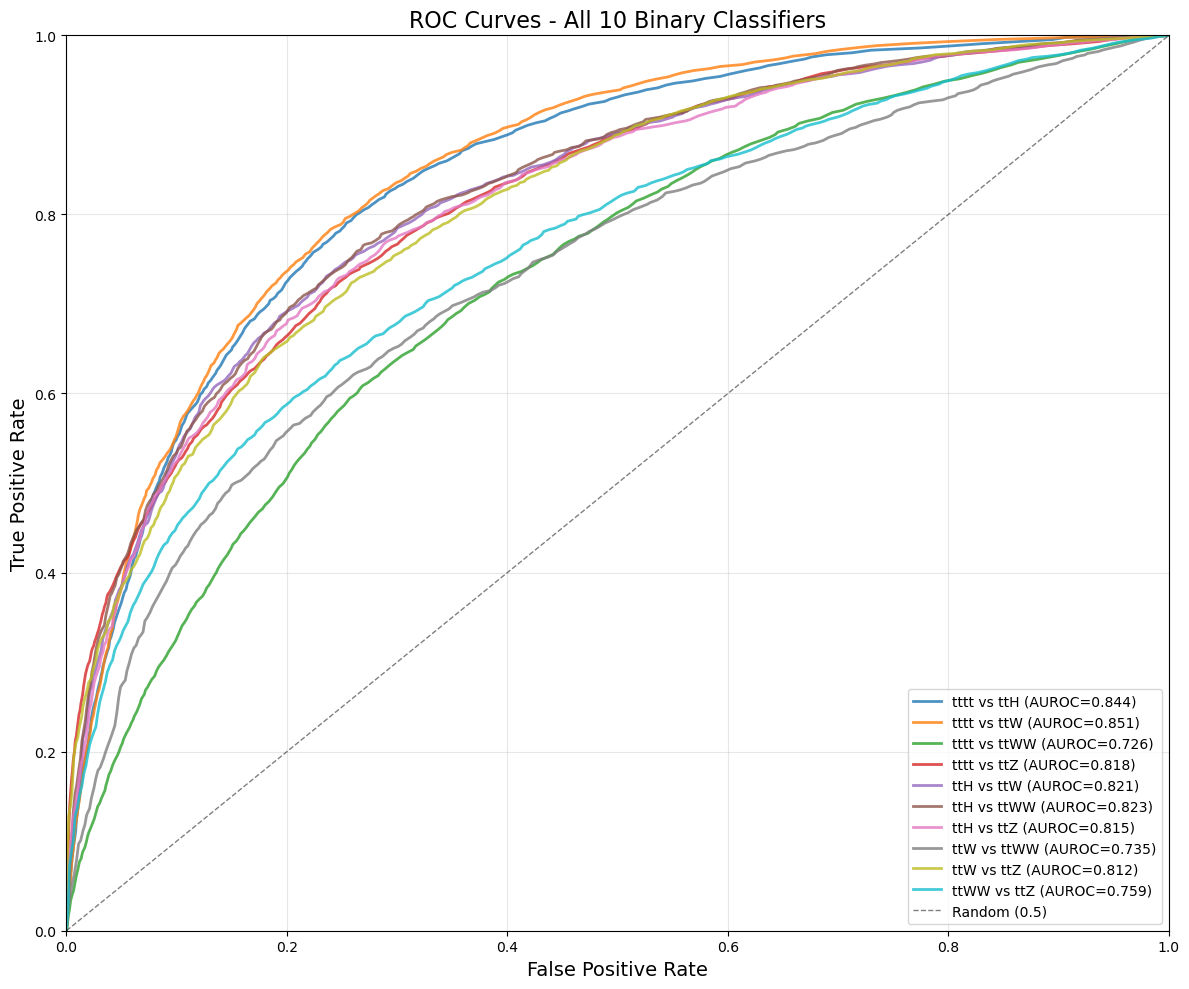

In [6]:
# Create a single plot with all 10 ROC curves
fig, ax = plt.subplots(figsize=(12, 10))

# Create mapping from run_id to label info
run_id_to_info = {info["run_id"]: info for info in run_info}

# Sort runs by label pair for consistent colors
sorted_run_ids = sorted(inference_results.keys(), key=lambda rid: run_id_to_info.get(rid, {}).get("label_pair", ""))

colors = plt.cm.tab10(np.linspace(0, 1, len(sorted_run_ids)))

for i, run_id in enumerate(sorted_run_ids):
    metrics = inference_results[run_id]
    roc_curves = metrics.get("roc_curves", {})
    
    if not roc_curves:
        continue
    
    # Get label pair info
    info = run_id_to_info.get(run_id, {})
    label_names = info.get("label_names", run_id)
    
    # For binary classification, plot single curve
    if len(roc_curves) == 1:
        class_idx = list(roc_curves.keys())[0]
        curve = roc_curves[class_idx]
        auroc = metrics.get("auroc", 0.0)
        ax.plot(
            curve["fpr"],
            curve["tpr"],
            label=f"{label_names} (AUROC={auroc:.3f})",
            color=colors[i],
            linewidth=2,
            alpha=0.8,
        )

# Diagonal reference line (random classifier)
ax.plot([0, 1], [0, 1], "k--", linewidth=1, alpha=0.5, label="Random (0.5)")

ax.set_xlabel("False Positive Rate", fontsize=14)
ax.set_ylabel("True Positive Rate", fontsize=14)
ax.set_title("ROC Curves - All 10 Binary Classifiers", fontsize=16)
ax.legend(fontsize=10, loc="lower right", ncol=1)
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()


## Plot 2: Pentagon Plot with AUC-ROC on Each Line


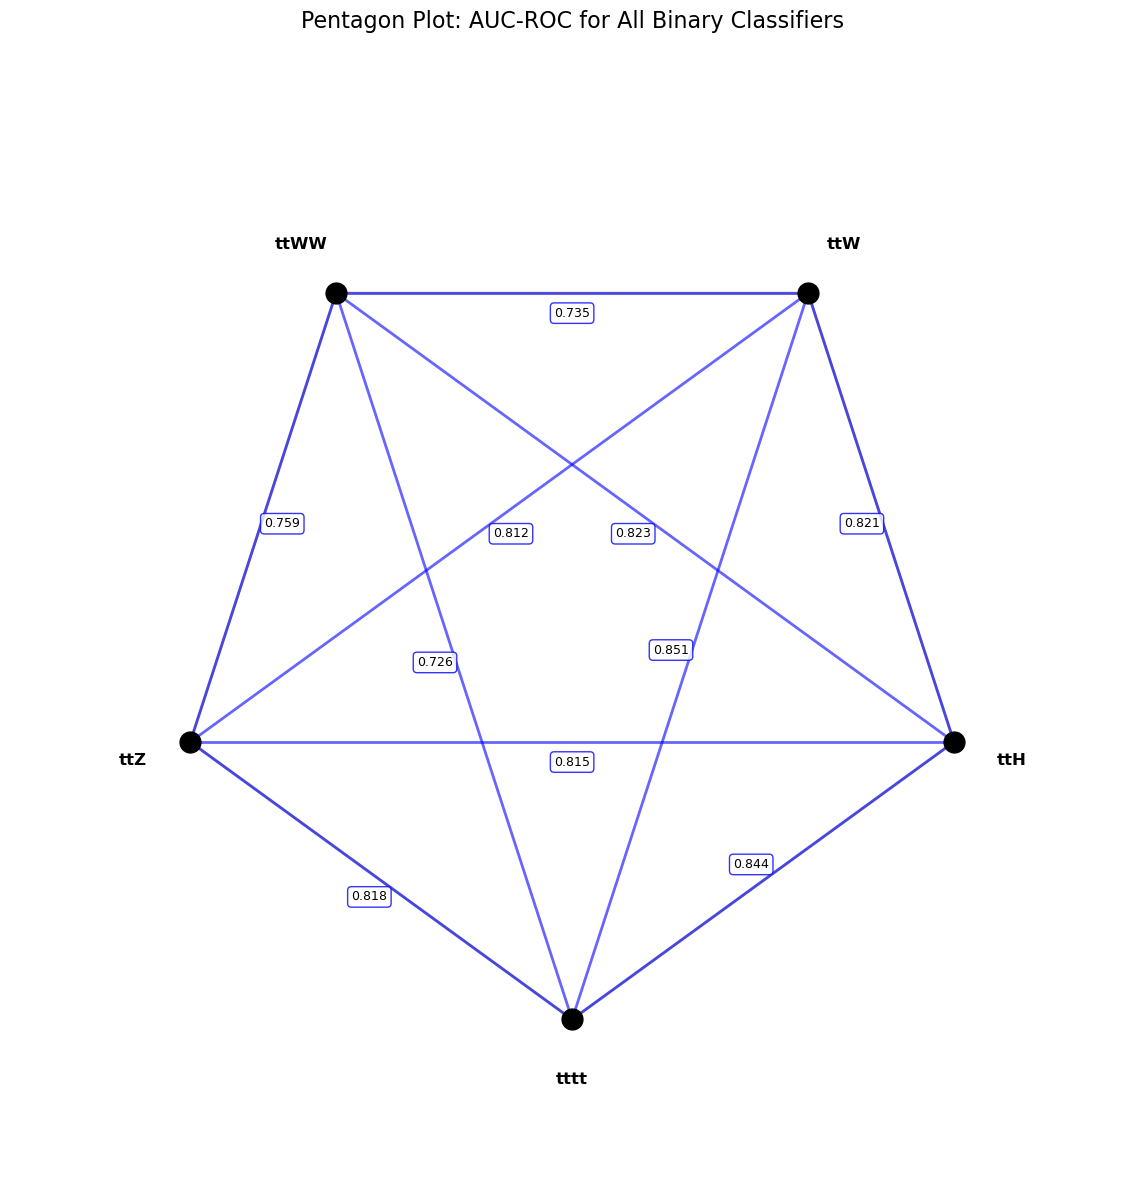

In [7]:
# Create pentagon plot
fig, ax = plt.subplots(figsize=(12, 12))

# Define pentagon vertices (5 classes at angles 0, 72, 144, 216, 288 degrees)
n_classes = 5
angles = np.linspace(0, 2 * np.pi, n_classes, endpoint=False)
# Start at top (90 degrees offset)
angles = angles - np.pi / 2

# Radius for vertices
radius = 1.0

# Calculate vertex positions
vertices = {}
label_to_angle = {}
for i, (label_id, label_name) in enumerate(sorted(LABEL_NAMES.items())):
    angle = angles[i]
    x = radius * np.cos(angle)
    y = radius * np.sin(angle)
    vertices[label_id] = (x, y, label_name)
    label_to_angle[label_id] = angle

# Draw pentagon outline
vertex_list = [vertices[i] for i in sorted(LABEL_NAMES.keys())]
vertex_x = [v[0] for v in vertex_list]
vertex_y = [v[1] for v in vertex_list]
# Close the pentagon
vertex_x.append(vertex_x[0])
vertex_y.append(vertex_y[0])
ax.plot(vertex_x, vertex_y, 'k-', linewidth=2, alpha=0.3)

# Plot vertices and labels
for label_id, (x, y, name) in vertices.items():
    ax.plot(x, y, 'ko', markersize=15, zorder=5)
    # Label position slightly outside vertex
    label_radius = radius * 1.15
    angle = label_to_angle[label_id]
    label_x = label_radius * np.cos(angle)
    label_y = label_radius * np.sin(angle)
    ax.text(label_x, label_y, name, ha='center', va='center', fontsize=12, fontweight='bold')

# Draw lines between pairs and add AUC-ROC labels
for info in run_info:
    label1, label2 = info["label1"], info["label2"]
    run_id = info["run_id"]
    
    if run_id not in inference_results:
        continue
    
    metrics = inference_results[run_id]
    auroc = metrics.get("auroc", None)
    
    if auroc is None:
        continue
    
    x1, y1, _ = vertices[label1]
    x2, y2, _ = vertices[label2]
    
    # Draw line
    ax.plot([x1, x2], [y1, y2], 'b-', linewidth=2, alpha=0.6)
    
    # Add AUC-ROC label at midpoint
    mid_x = (x1 + x2) / 2
    mid_y = (y1 + y2) / 2
    # Offset slightly perpendicular to line
    dx = x2 - x1
    dy = y2 - y1
    perp_x = -dy
    perp_y = dx
    norm = np.sqrt(perp_x**2 + perp_y**2)
    if norm > 0:
        perp_x /= norm
        perp_y /= norm
    offset = 0.05
    label_x = mid_x + offset * perp_x
    label_y = mid_y + offset * perp_y
    
    ax.text(label_x, label_y, f'{auroc:.3f}', 
            ha='center', va='center', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='blue'))

ax.set_xlim([-1.4, 1.4])
ax.set_ylim([-1.4, 1.4])
ax.set_aspect('equal')
ax.axis('off')
ax.set_title("Pentagon Plot: AUC-ROC for All Binary Classifiers", fontsize=16, pad=20)

plt.tight_layout()
plt.show()


## Plot 3: 10 Individual Score Distribution Plots


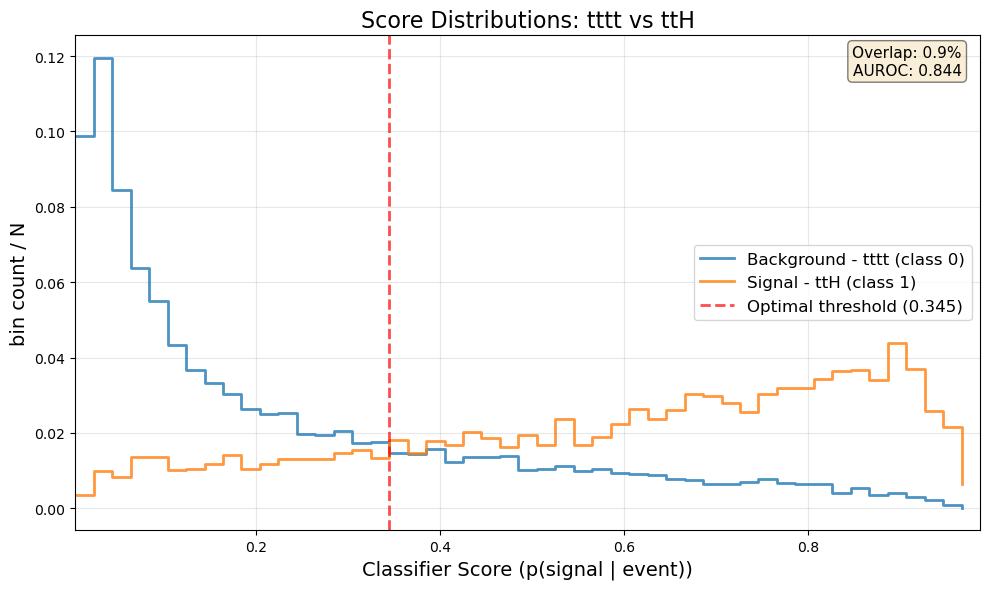

Created plot for tttt vs ttH


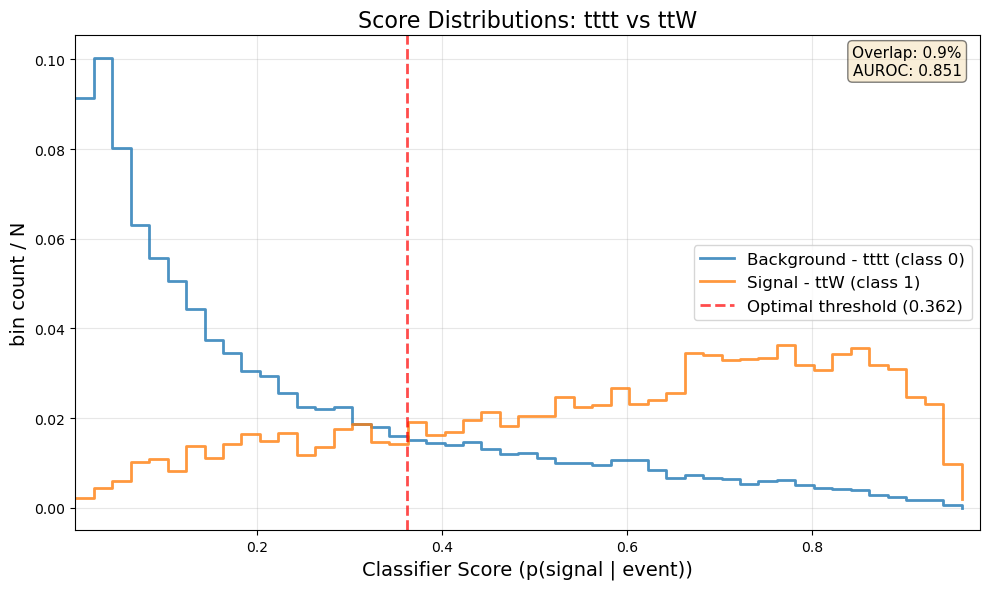

Created plot for tttt vs ttW


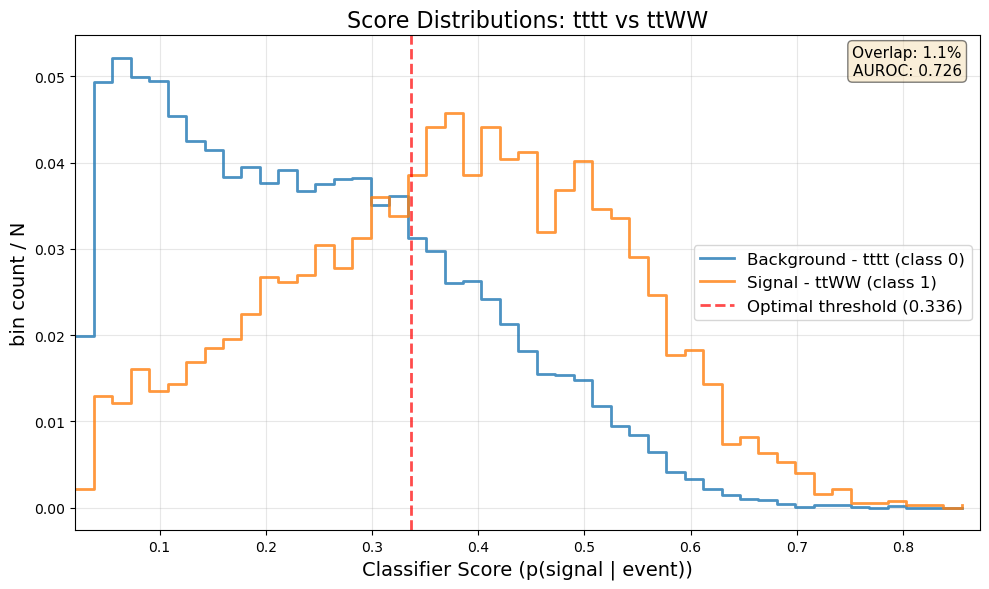

Created plot for tttt vs ttWW


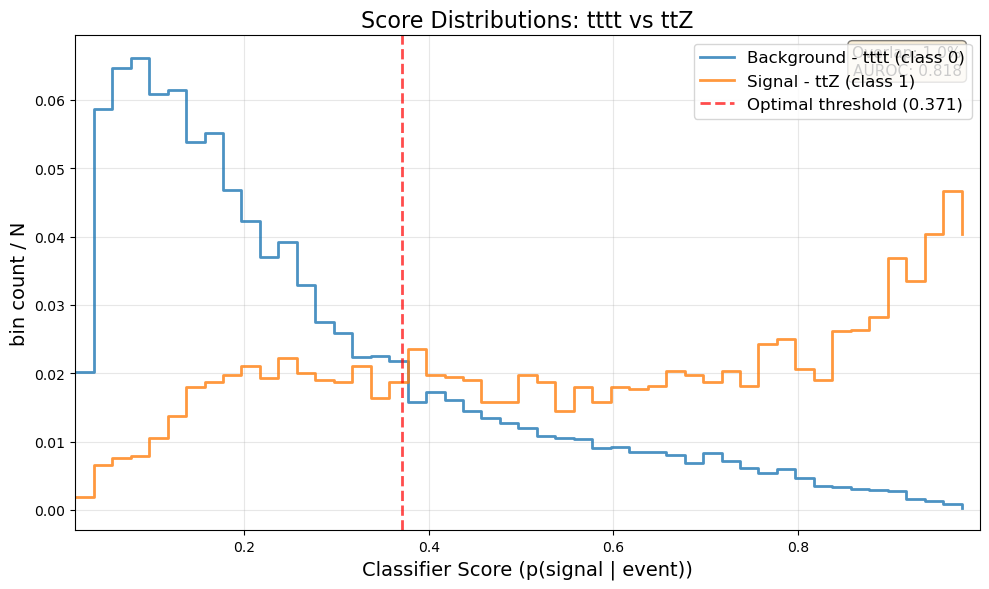

Created plot for tttt vs ttZ


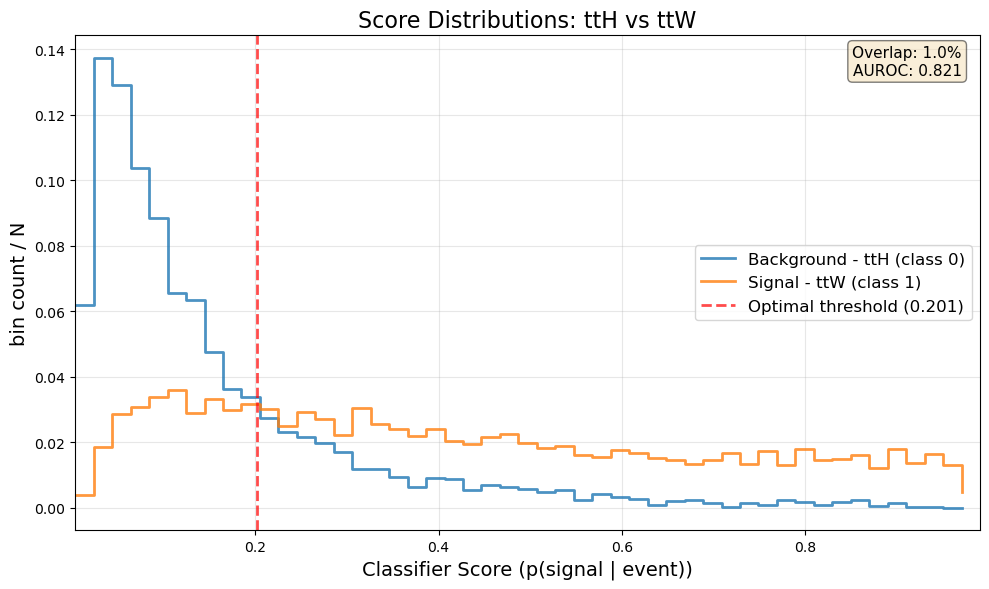

Created plot for ttH vs ttW


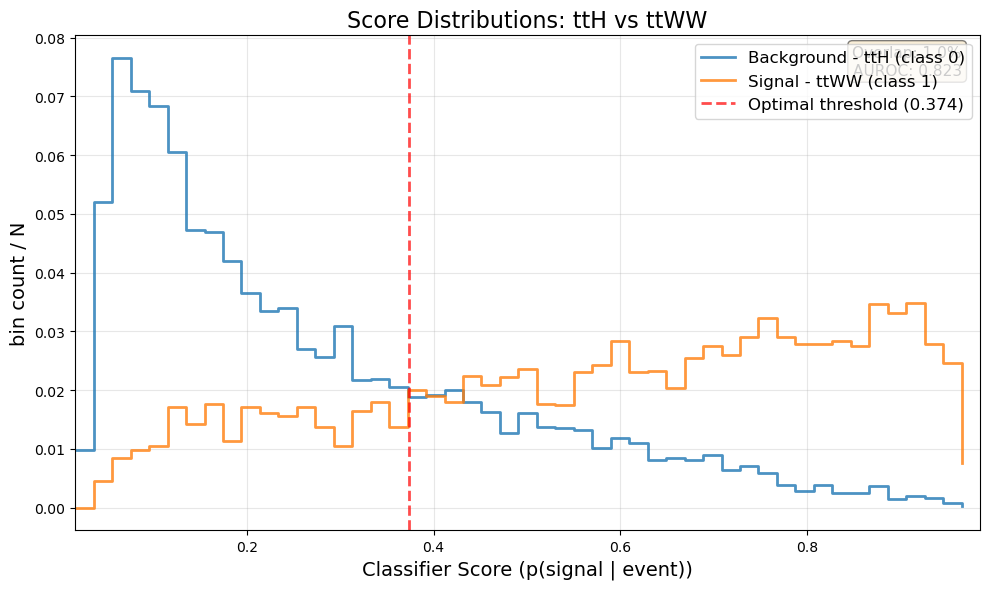

Created plot for ttH vs ttWW


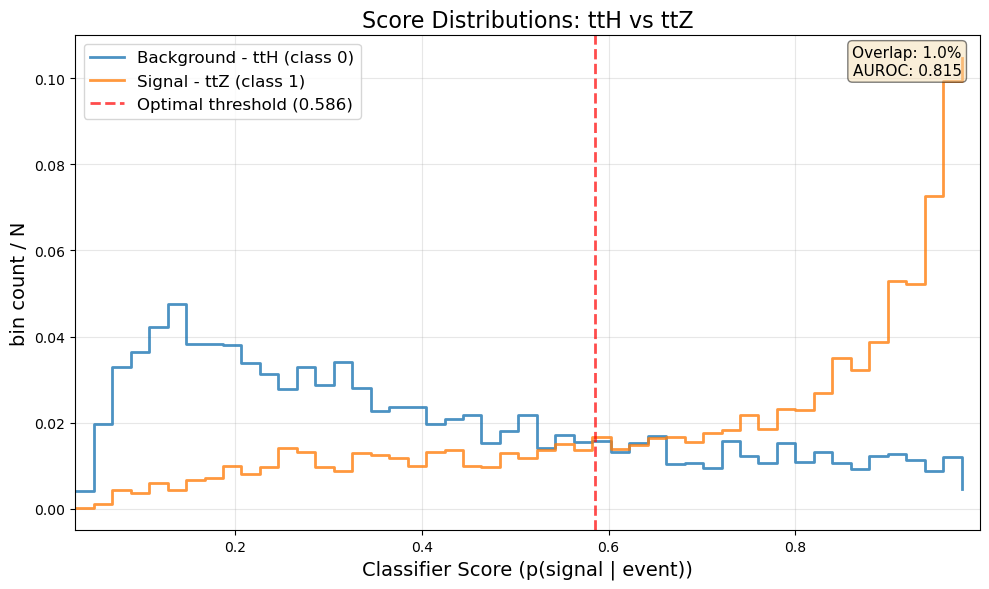

Created plot for ttH vs ttZ


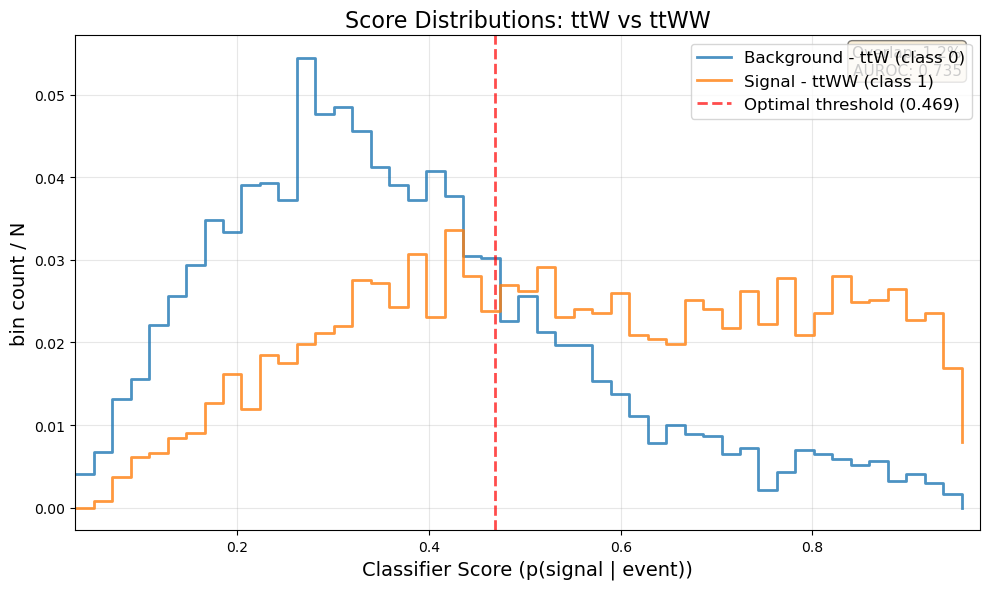

Created plot for ttW vs ttWW


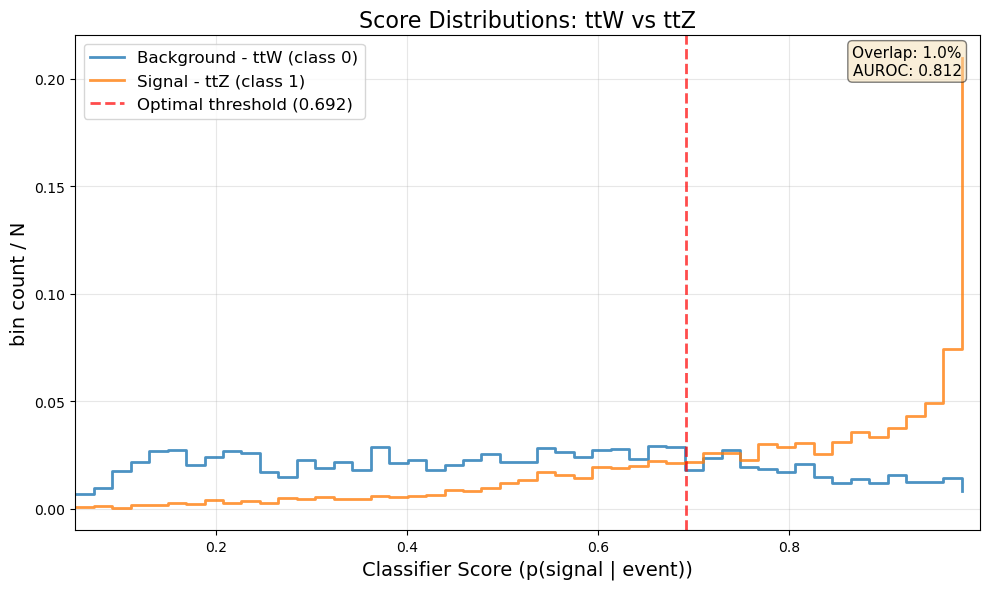

Created plot for ttW vs ttZ


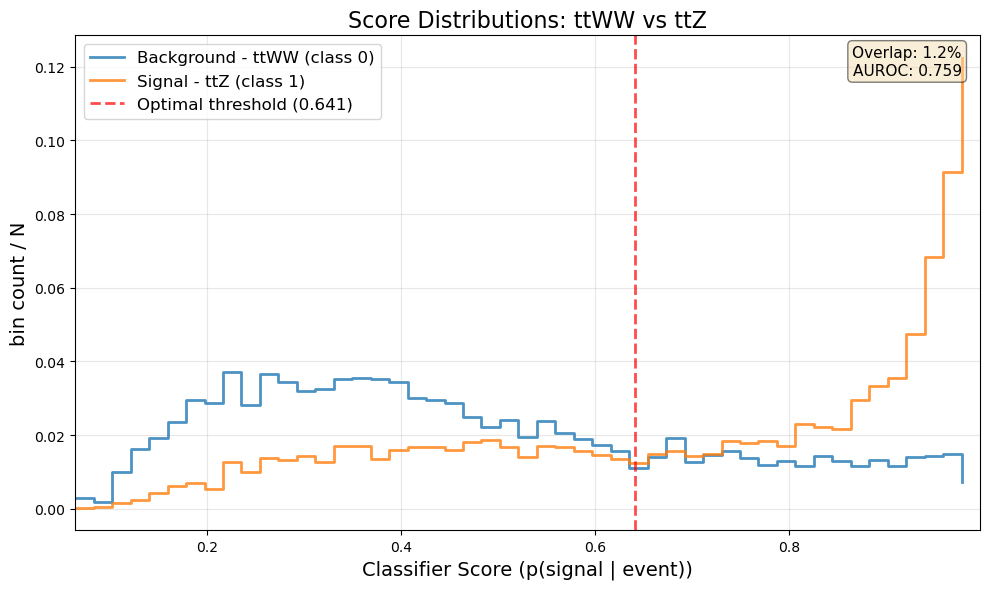

Created plot for ttWW vs ttZ

All score distribution plots created!


In [8]:
# Create 10 individual score distribution plots
# Using the plot_score_distributions function from classification.py
# We'll create a custom version that works in notebook context

from sklearn.metrics import roc_curve

# Create a temporary directory for saving (or just display)
figs_dir = Path("temp_figs")
figs_dir.mkdir(exist_ok=True)

# Figure config
fig_cfg = {"fig_format": "png", "dpi": 150}

# Create plots for each run
for info in run_info:
    run_id = info["run_id"]
    
    if run_id not in inference_results:
        continue
    
    metrics = inference_results[run_id]
    
    # Extract per-event scores and labels
    per_event_scores = metrics.get("per_event_scores")
    per_event_labels = metrics.get("per_event_labels")
    
    if per_event_scores is None or per_event_labels is None:
        print(f"Skipping {run_id}: missing per_event data")
        continue
    
    scores = np.array(per_event_scores)  # [N] - p(signal | event)
    labels = np.array(per_event_labels)  # [N] - true labels
    
    # Split into signal and background
    # In binary classification: label1 maps to class 0, label2 maps to class 1
    # So class 1 (label2) is signal, class 0 (label1) is background
    signal_class_idx = 1  # This corresponds to label2
    background_class_idx = 0  # This corresponds to label1
    signal_scores = scores[labels == signal_class_idx]
    background_scores = scores[labels == background_class_idx]
    
    if len(signal_scores) == 0 or len(background_scores) == 0:
        print(f"Skipping {run_id}: missing one class")
        continue
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Compute optimal threshold using Youden's J
    y_binary = (labels == signal_class_idx).astype(int)
    fpr, tpr, thresholds = roc_curve(y_binary, scores)
    youden_j = tpr - fpr
    optimal_idx = np.argmax(youden_j)
    optimal_threshold = thresholds[optimal_idx]
    
    # Compute overlap area
    score_min = min(scores.min(), background_scores.min(), signal_scores.min())
    score_max = max(scores.max(), background_scores.max(), signal_scores.max())
    bins = np.linspace(score_min, score_max, 50)
    
    # Compute normalized histograms
    bg_counts, bg_edges = np.histogram(background_scores, bins=bins)
    sig_counts, sig_edges = np.histogram(signal_scores, bins=bins)
    
    # Normalize by total count
    bg_normalized = bg_counts / len(background_scores)
    sig_normalized = sig_counts / len(signal_scores)
    
    # Compute overlap
    overlap = np.minimum(bg_normalized, sig_normalized)
    overlap_area = np.sum(overlap) * (bins[1] - bins[0])
    
    # Plot normalized step histograms
    # Note: label1 → class 0 (background), label2 → class 1 (signal)
    ax.step(
        bg_edges[:-1],
        bg_normalized,
        where="post",
        label=f"Background - {LABEL_NAMES[info['label1']]} (class 0)",
        color="#1f77b4",  # Blue
        linewidth=2,
        alpha=0.8,
    )
    ax.step(
        sig_edges[:-1],
        sig_normalized,
        where="post",
        label=f"Signal - {LABEL_NAMES[info['label2']]} (class 1)",
        color="#ff7f0e",  # Orange
        linewidth=2,
        alpha=0.8,
    )
    
    # Plot optimal threshold line
    ax.axvline(
        optimal_threshold,
        color="red",
        linestyle="--",
        linewidth=2,
        alpha=0.7,
        label=f"Optimal threshold ({optimal_threshold:.3f})",
    )
    
    # Annotate overlap area
    overlap_pct = overlap_area * 100
    auroc = metrics.get("auroc", 0.0)
    ax.text(
        0.98,
        0.98,
        f"Overlap: {overlap_pct:.1f}%\nAUROC: {auroc:.3f}",
        transform=ax.transAxes,
        ha="right",
        va="top",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
        fontsize=11,
    )
    
    # Set labels and title
    ax.set_xlabel("Classifier Score (p(signal | event))", fontsize=14)
    ax.set_ylabel("bin count / N", fontsize=14)
    ax.set_title(f"Score Distributions: {info['label_names']}", fontsize=16)
    ax.legend(fontsize=12)
    ax.grid(alpha=0.3)
    ax.set_xlim([score_min, score_max])
    
    plt.tight_layout()
    plt.show()
    
    print(f"Created plot for {info['label_names']}")

print("\nAll score distribution plots created!")


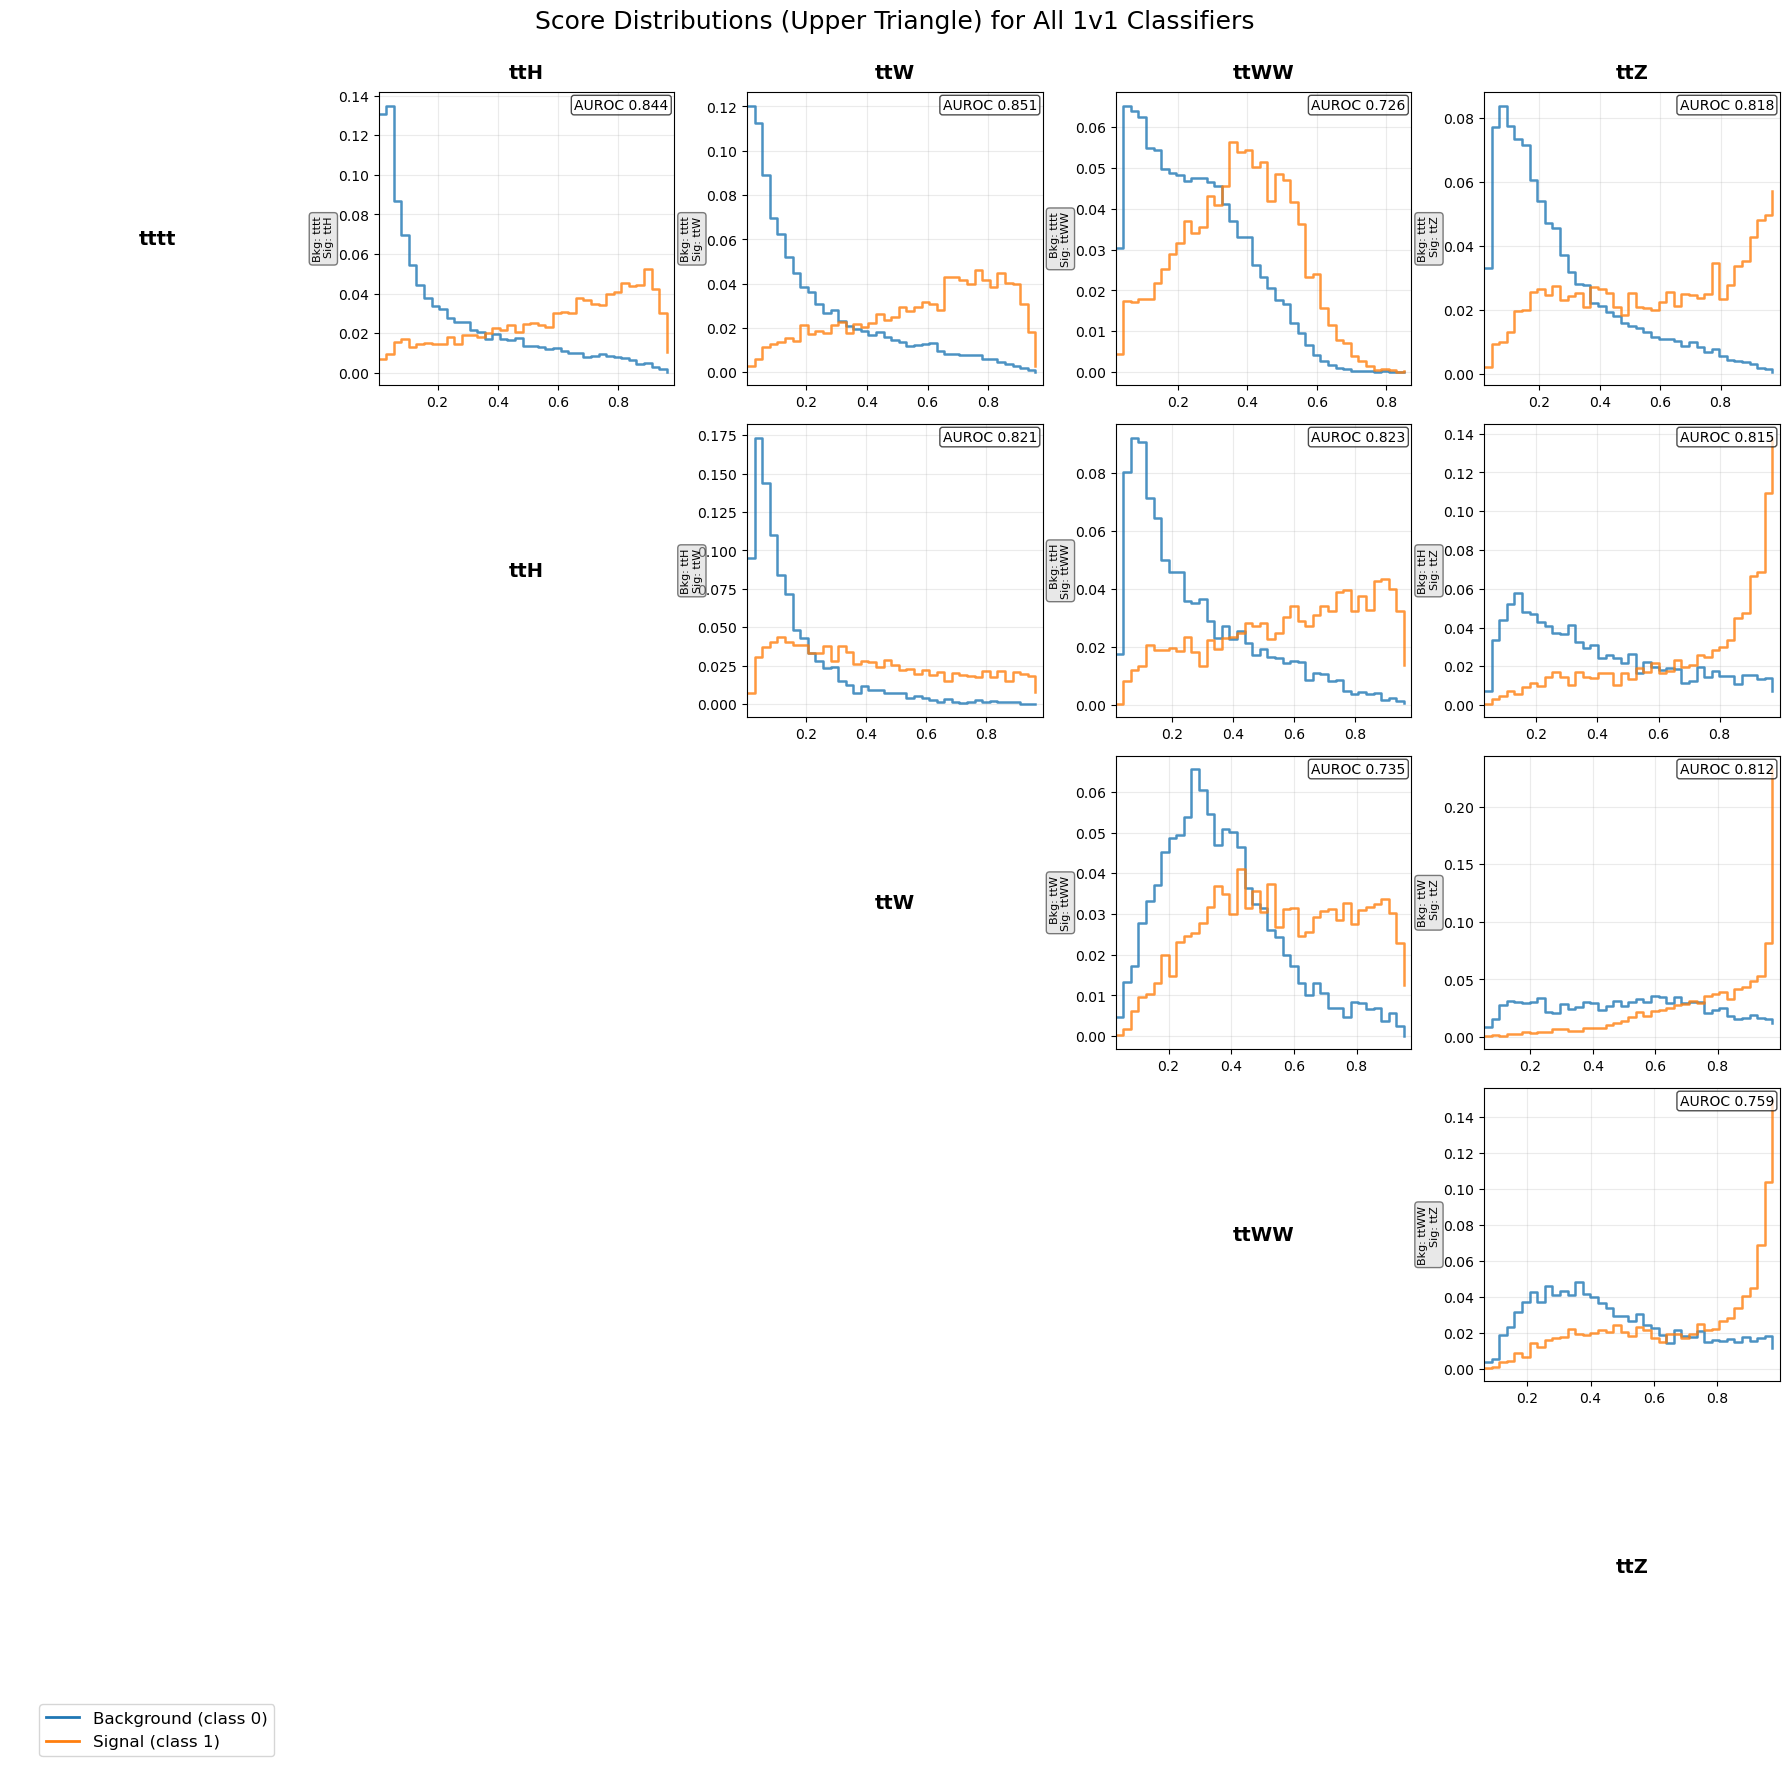

In [ ]:
# Plot 4: 5x5 upper-triangular grid of score distributions (one picture with all pairs)
from matplotlib.lines import Line2D

label_ids = sorted(LABEL_NAMES.keys())  # [1,2,3,4,5]
num_labels = len(label_ids)

# Map (label_i, label_j) -> run_id and get label info
pair_to_run = {}
pair_to_info = {}
for info in run_info:
    l1, l2 = info["label1"], info["label2"]
    key = (min(l1, l2), max(l1, l2))
    pair_to_run[key] = info["run_id"]
    pair_to_info[key] = info

fig, axes = plt.subplots(num_labels, num_labels, figsize=(18, 18), sharex=False, sharey=False)

for i in range(num_labels):
    for j in range(num_labels):
        ax = axes[i, j]
        li = label_ids[i]
        lj = label_ids[j]

        if i == j:
            # Diagonal: class label
            ax.axis("off")
            ax.text(0.5, 0.5, LABEL_NAMES[li], ha="center", va="center", 
                   fontsize=14, fontweight="bold", transform=ax.transAxes)
            continue

        if i > j:
            # Lower triangle: hide (will use for legend)
            ax.axis("off")
            continue

        # Upper triangle: plot the distribution for (li, lj)
        pair = (li, lj)
        run_id = pair_to_run.get(pair)
        info = pair_to_info.get(pair)
        
        if run_id is None or run_id not in inference_results:
            ax.axis("off")
            ax.text(0.5, 0.5, "N/A", ha="center", va="center", fontsize=12, transform=ax.transAxes)
            continue

        metrics = inference_results[run_id]
        per_event_scores = metrics.get("per_event_scores")
        per_event_labels = metrics.get("per_event_labels")

        if per_event_scores is None or per_event_labels is None:
            ax.axis("off")
            ax.text(0.5, 0.5, "No data", ha="center", va="center", fontsize=12, transform=ax.transAxes)
            continue

        scores = np.asarray(per_event_scores)
        labels = np.asarray(per_event_labels)

        # Binary mapping in our pipeline: label1 -> class 0 (background), label2 -> class 1 (signal)
        bg_scores = scores[labels == 0]
        sig_scores = scores[labels == 1]

        if bg_scores.size == 0 or sig_scores.size == 0:
            ax.axis("off")
            ax.text(0.5, 0.5, "Missing class", ha="center", va="center", fontsize=12, transform=ax.transAxes)
            continue

        # Common binning
        smin = float(min(scores.min(), bg_scores.min(), sig_scores.min()))
        smax = float(max(scores.max(), bg_scores.max(), sig_scores.max()))
        if smin == smax:
            smin, smax = 0.0, 1.0
        bins = np.linspace(smin, smax, 40)

        # Hist counts (normalized by sample count to show per-event fraction)
        bg_counts, bg_edges = np.histogram(bg_scores, bins=bins)
        sig_counts, sig_edges = np.histogram(sig_scores, bins=bins)
        bg_norm = bg_counts / max(len(bg_scores), 1)
        sig_norm = sig_counts / max(len(sig_scores), 1)

        # Plot step histograms
        ax.step(bg_edges[:-1], bg_norm, where="post", color="#1f77b4", linewidth=1.8, alpha=0.8)
        ax.step(sig_edges[:-1], sig_norm, where="post", color="#ff7f0e", linewidth=1.8, alpha=0.8)

        # AUROC annotation
        auroc = metrics.get("auroc", None)
        if isinstance(auroc, int | float):
            ax.text(0.98, 0.98, f"AUROC {auroc:.3f}", ha="right", va="top", transform=ax.transAxes,
                    fontsize=10, bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.7))

        # Add signal/background labels (vertical text on y-axis)
        if info:
            bg_name = LABEL_NAMES[info["label1"]]  # label1 -> class 0 (background)
            sig_name = LABEL_NAMES[info["label2"]]  # label2 -> class 1 (signal)
            # Add vertical text labels on the left side
            ax.text(-0.15, 0.5, f"Bkg: {bg_name}\nSig: {sig_name}", 
                   ha="right", va="center", transform=ax.transAxes,
                   fontsize=8, rotation=90, 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.5))

        # Axis cosmetics - top labels same as diagonal (bold, size 14)
        if i == 0:
            ax.set_title(f"{LABEL_NAMES[lj]}", fontsize=14, fontweight="bold", pad=10)
        if j == 0:
            ax.set_ylabel(f"{LABEL_NAMES[li]}", fontsize=14, fontweight="bold")

        ax.grid(alpha=0.25)
        ax.set_xlim([smin, smax])

# Add legend in bottom left corner (lower triangle area)
legend_elems = [
    Line2D([0], [0], color="#1f77b4", lw=2, label="Background (class 0)"),
    Line2D([0], [0], color="#ff7f0e", lw=2, label="Signal (class 1)"),
]
# Place legend in the bottom-left subplot (axes[4, 0] which is lower triangle)
fig.legend(handles=legend_elems, loc="lower left", bbox_to_anchor=(0.02, 0.02), fontsize=12, frameon=True)

# Put title much closer to the plots
fig.suptitle("Score Distributions (Upper Triangle) for All 1v1 Classifiers", 
            fontsize=18, y=0.995)
# Adjust layout - less padding at top since title is closer
plt.tight_layout(rect=[0.0, 0.04, 1, 0.995])
plt.show()



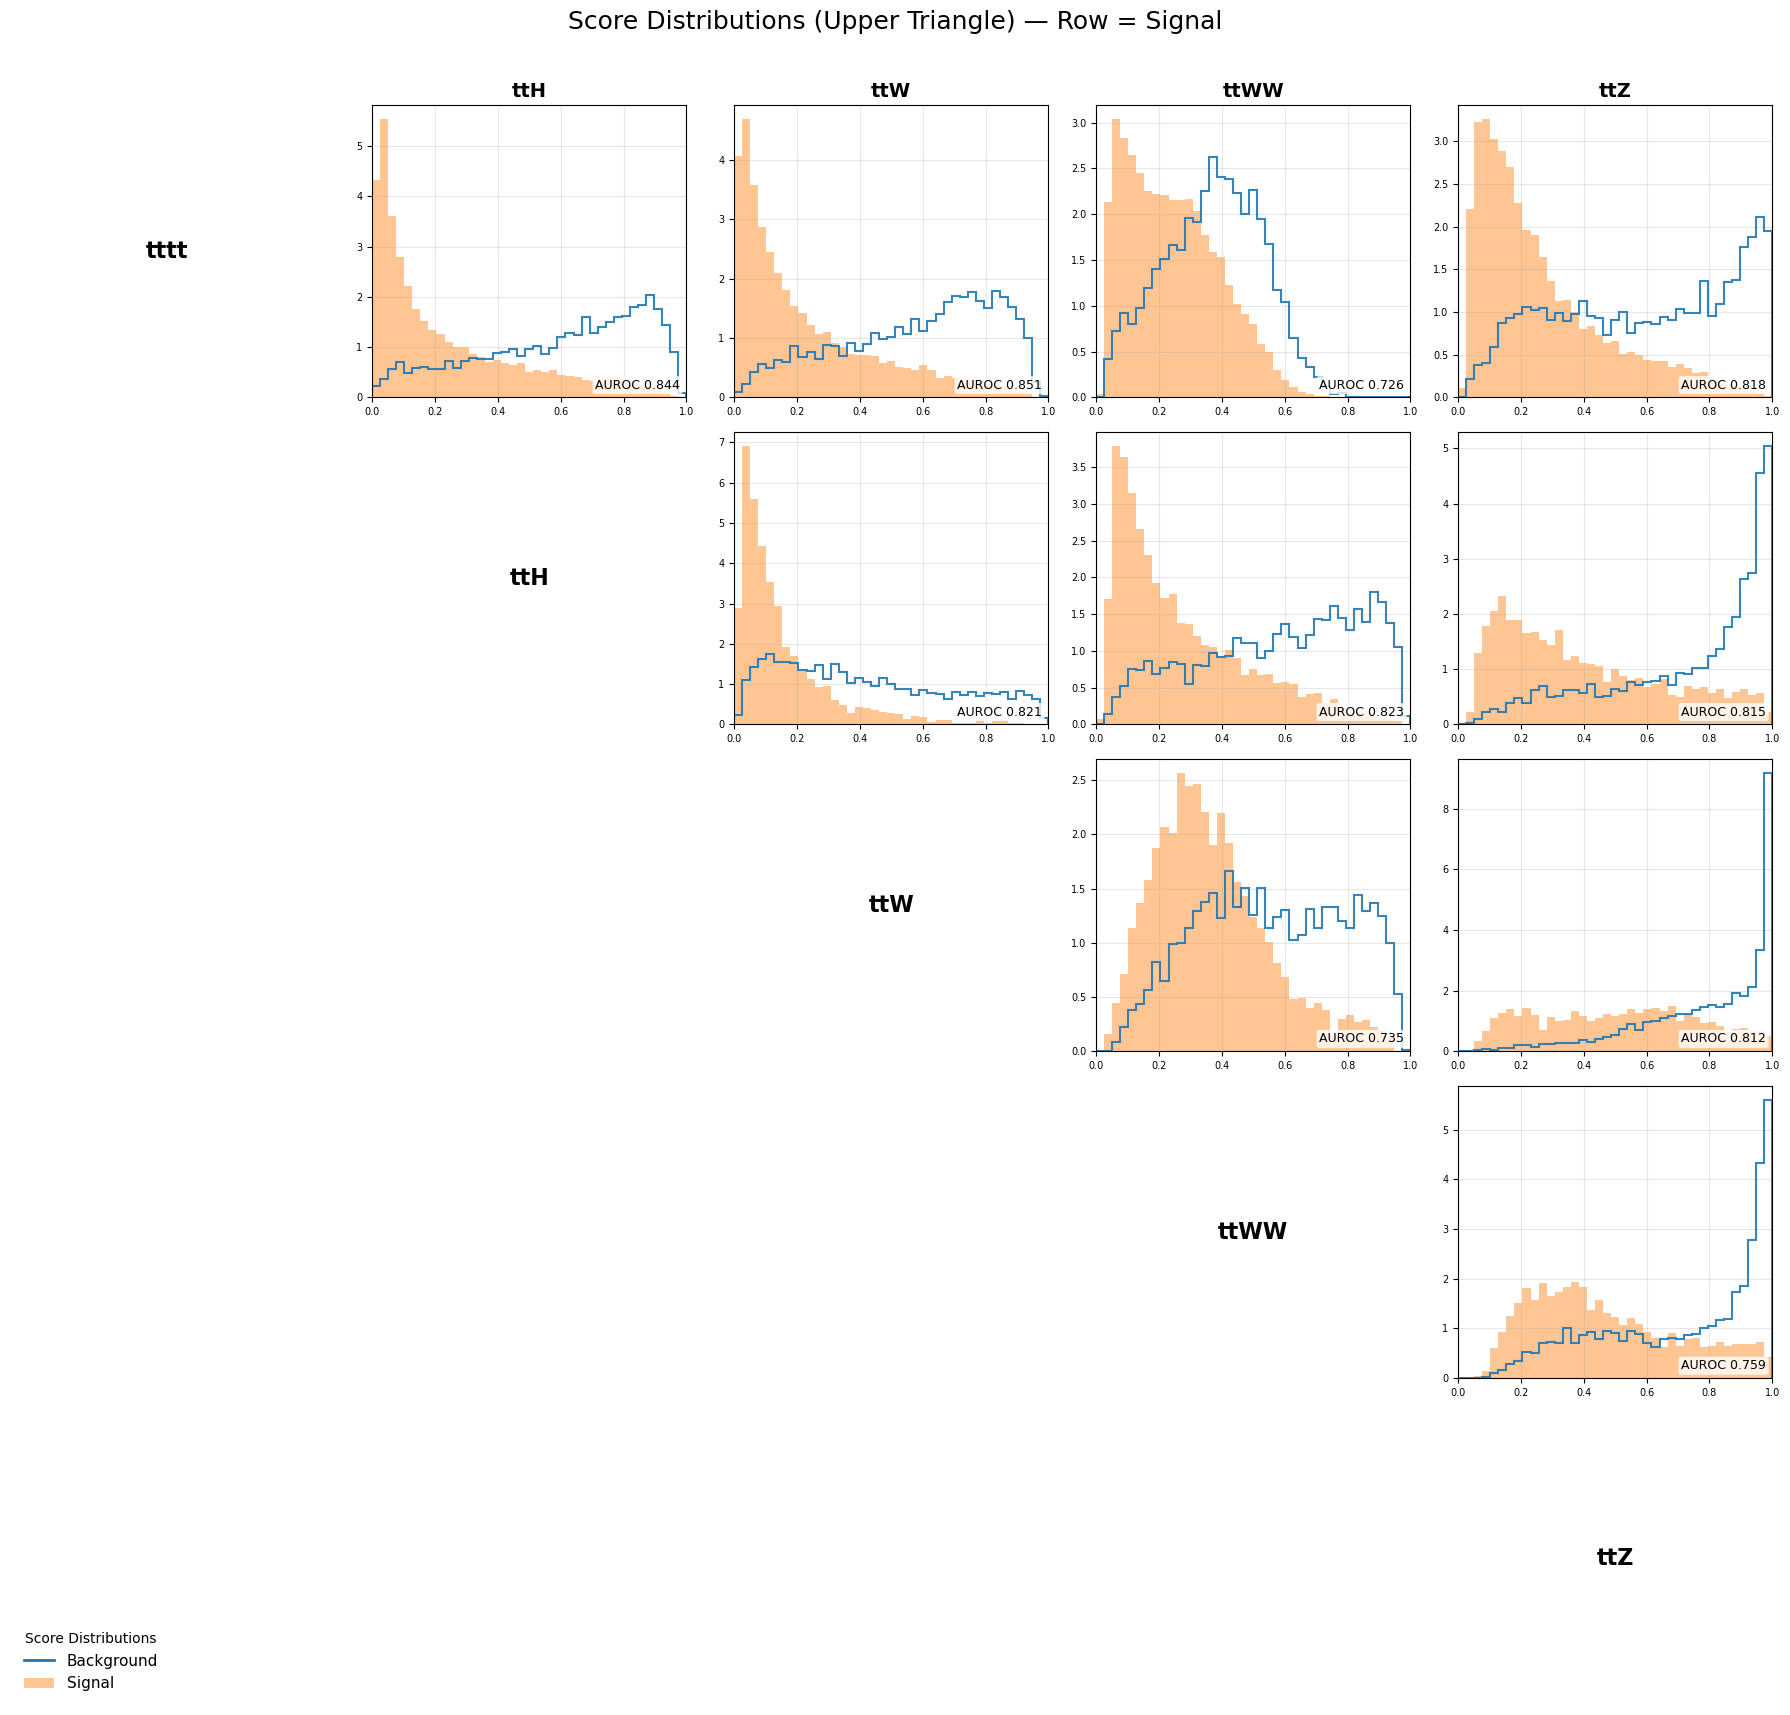

In [ ]:
# === 5x5 UPPER-TRIANGULAR SCORE MATRIX (ROW = SIGNAL) ===
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

label_ids = sorted(LABEL_NAMES.keys())  # e.g. [1,2,3,4,5]
num_labels = len(label_ids)

# Build lookup tables
pair_to_run = {}
pair_to_info = {}
for info in run_info:
    l1, l2 = info["label1"], info["label2"]
    key = (min(l1, l2), max(l1, l2))
    pair_to_run[key] = info["run_id"]
    pair_to_info[key] = info

fig, axes = plt.subplots(num_labels, num_labels, figsize=(18, 18))

for i, li in enumerate(label_ids):
    for j, lj in enumerate(label_ids):
        ax = axes[i, j]

        # Diagonal cell → large label name
        if i == j:
            ax.axis("off")
            ax.text(0.5, 0.5, LABEL_NAMES[li],
                    ha="center", va="center",
                    fontsize=16, fontweight="bold",
                    transform=ax.transAxes)
            continue

        # Lower triangle → empty, reserved for legend etc.
        if i > j:
            ax.axis("off")
            continue

        # --- Determine run_id for (li, lj) ---
        key = (min(li, lj), max(li, lj))
        run_id = pair_to_run.get(key, None)
        info = pair_to_info.get(key, None)

        if run_id is None or run_id not in inference_results:
            ax.axis("off")
            ax.text(0.5, 0.5, "N/A", ha="center", va="center")
            continue

        metrics = inference_results[run_id]
        scores = np.asarray(metrics["per_event_scores"])
        labels = np.asarray(metrics["per_event_labels"])

        # OLD meaning in inference:
        #   label1 → class0 (background)
        #   label2 → class1 (signal)
        # identify the meaning in the run
        run_label1 = info["label1"]
        run_label2 = info["label2"]

        # fetch the raw scores
        bg_raw = scores[labels == 0]   # corresponds to run_label1
        sig_raw = scores[labels == 1]  # corresponds to run_label2

        # --- ENFORCE OUR NEW CONVENTION ---
        # signal = row label (li)
        # background = column label (lj)
        if li == run_label2 and lj == run_label1:
            # Perfect match → already li=signal, lj=background
            sig_scores = sig_raw
            bg_scores = bg_raw
        else:
            # Model was trained in the opposite direction → FLIP
            sig_scores = bg_raw
            bg_scores = sig_raw

        # Histogram range
        bins = np.linspace(0.0, 1.0, 40)

        # Plot histogram: background blue outline, signal orange fill
        ax.hist(bg_scores, bins=bins, density=True,
                histtype="step", linewidth=1.5, color="#1f77b4", alpha=0.9)
        ax.hist(sig_scores, bins=bins, density=True,
                histtype="stepfilled", alpha=0.45, color="#ff7f0e")

        # AUROC
        auroc = metrics.get("auroc", None)
        if isinstance(auroc, float):
            ax.text(0.98, 0.02, f"AUROC {auroc:.3f}",
                    ha="right", va="bottom",
                    transform=ax.transAxes,
                    fontsize=9,
                    bbox=dict(boxstyle="round,pad=0.2",
                              fc="white", ec="none", alpha=0.8))

        # Titles
        if i == 0:
            ax.set_title(LABEL_NAMES[lj], fontsize=14, fontweight="bold")
        if j == 0:
            ax.set_ylabel(LABEL_NAMES[li], fontsize=14, fontweight="bold")

        ax.set_xlim(0, 1)
        ax.tick_params(axis="both", labelsize=7)
        ax.grid(alpha=0.3)

# --- Legend inside lower-left triangle ---
handles = [
    Line2D([], [], color="#1f77b4", lw=2, label="Background"),
    Patch(facecolor="#ff7f0e", alpha=0.45, label="Signal")
]

legend_ax = axes[-1, 0]
legend_ax.axis("off")
legend_ax.legend(handles=handles, loc="lower left",
                 fontsize=11, frameon=False,
                 title="Score Distributions")

# Title + layout
fig.suptitle("Score Distributions (Upper Triangle) — Row = Signal", fontsize=18, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()
